# Data Analysis for J12 Pitch
This notebook analyses data gathered from Dealroom in order to guide the startup pitch for venture analyst position at J12

The goal of the analysis is to find outliers in the data - i.e. companies that distinguish themselves from the pack

In addition we look at companies with a high valuation and try to find similar companies with a low valuation

In [216]:
# Begin by importing relevant packages
import pandas as pd
import seaborn as sns
import matplotlib as plt
import utils
from imp import reload
import numpy as np
import sklearn.neighbors as NN
import geopandas as gpd
import contextily as ctx
import pygeos

sns.set_theme()

# Colours from medialab.github.io/iwanthue
colours = ["#7a75cc",
"#6ca74d",
"#c45ca2",
"#49adab",
"#cb584c",
"#b88f40"]


## Initial look at data
We begin by having a look at the data - it contains around 800 companies and 99 columns

In [217]:
# Load the initial data file and look at the top data
# Data retrieved from dealroom
companies = pd.read_csv('./companies_03_03_21_1614761500.csv', sep = ',')
# Make name the index
companies.index = companies.NAME
companies['VALUATION (EUR)'] = companies['VALUATION (EUR)'].apply(utils.intervalMid)
companies.head()

,id,NAME,PROFILE URL,WEBSITE,TAGLINE,ADDRESS,HQ REGION,HQ COUNTRY,HQ CITY,LATITUDE,...,SIMILARWEB RANK 3/6/12 MONTHS,EMPLOYEE RANK 3/6/12 MONTHS,APP RANK 3/6/12 MONTHS,NUMBER OF ALUMNI EUROPEAN FOUNDERS THAT RAISED > 10M,TECHNOLOGIES,INCOME STREAMS,TECH STACK DATA (BY PREDICTLEADS),TRADE REGISTER NUMBER,SDGS,CORE SIDE VALUE
NAME,,,,,,,,,,,,,,,,,,,,,
Agapi Club,912963,Agapi Club,https://app.dealroom.co/companies/agapi_club,http://agapiboating.com/sv/,Unique and exclusive membership club that open...,"Biskopsvägen 7, 115 21 Stockholm, Sweden",Europe,Sweden,NaN,59.321160,...,top 25%;top 25%;top 25%,n/a;n/a;n/a,n/a;n/a;n/a,0,NaN,subscription,addthis;cloudflare cdn;facebook;facebook pixel...,NaN,NaN,NaN
Mink Campers,909196,Mink Campers,https://app.dealroom.co/companies/mink_campers,https://minkcampers.com/,Quality travel experiences in nature,"Strandgata 90, 220 Hafnarfjörður, Iceland",Europe,Iceland,Hafnarfjörður,64.062459,...,top 10%;n/a;n/a,n/a;n/a;n/a,n/a;n/a;n/a,0,NaN,NaN,crazy egg;facebook;facebook pixel;google analy...,NaN,NaN,NaN
Hoofstep,928684,Hoofstep,https://app.dealroom.co/companies/hoofstep,http://www.hoofstep.com/,Develops horse monitoring systems,"Järnvägsgatan 7, 252 24 Helsingborg, Sweden",Europe,Sweden,Helsingborg,56.045255,...,top half;top half;top half,n/a;n/a;n/a,n/a;n/a;n/a,0,big data;deep tech,NaN,dojo;facebook;facebook pixel;google analytics;...,"559043-4667 (Helsingborg, Sweden)",NaN,NaN
Estaldo.com,1784560,Estaldo.com,https://app.dealroom.co/companies/estaldo_com,https://estaldo.com,A new and different real estate agent,"Østergade 47, 9400 Nørresundby, Denmark",Europe,Denmark,Nørresundby,57.060181,...,n/a;n/a;n/a,n/a;n/a;n/a,n/a;n/a;n/a,0,NaN,commission,cloudflare cdn;facebook;facebook pixel;google ...,"40415807 (Nørresundby, Denmark)",NaN,NaN
LiveRing,887540,LiveRing,https://app.dealroom.co/companies/livering,https://livering.com,"Many-to-many LIVE video, share your moments wi...","Mannerheimintie 15, 00260 Helsinki, Finland",Europe,Finland,Helsinki,60.166955,...,top 25%;top 25%;n/a,n/a;n/a;n/a,n/a;n/a;n/a,0,NaN,NaN,amazon web services;bootstrap;express;facebook...,NaN,NaN,NaN


## Look at valuations
The valuation of a company gives you an estimate of the cost of investing in that company

Companies with larger valuations are going to be more expensive - but the market believes in the success of the company

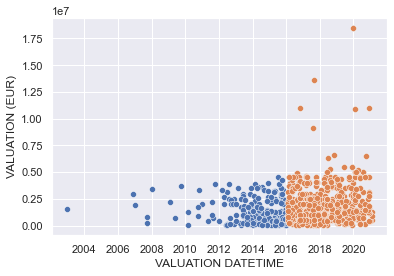

In [218]:
# Set datetime for plotting and plot valuation against date
companies['VALUATION DATETIME'] = pd.to_datetime(companies['VALUATION DATE'])
ax1 = sns.scatterplot(x = companies['VALUATION DATETIME'], y = companies['VALUATION (EUR)'])
companies2016 = companies[companies['VALUATION DATETIME']>pd.to_datetime(2016,format='%Y')]
ax2 = sns.scatterplot(x = companies2016['VALUATION DATETIME'], y = companies2016['VALUATION (EUR)'])

### Many companies have old valuations - we restrict our analysis to companies which have a valuation from 2016 and onwards

### Lets look at the distribution of valuations for these companies

Outliers for threshold: 4
              VALUATION (EUR)  score
NAME                                
Cerebriu           10909091.0    5.0
Fellow Pay         11000000.0    5.0
AuctioNet          11001100.0    5.0
Blue Lice           9090908.0    4.0
Formulate AB       18500000.0    9.0
Elly Pistol        13636363.0    7.0

Descriptive stats of Valuations
count         567.0
mean      1983061.0
std       1742437.0
min         37500.0
25%        825082.0
50%       1600000.0
75%       2738636.0
max      18500000.0
Name: VALUATION (EUR), dtype: float64


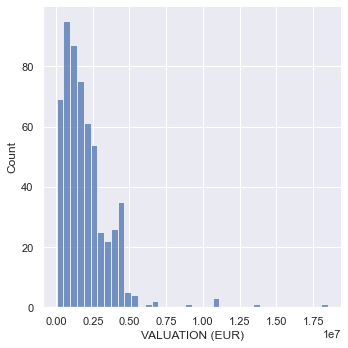

In [219]:
feature = 'VALUATION (EUR)'
reload(utils)
numCompanies = companies2016.select_dtypes([np.number]).dropna(how='all')
sns.displot(numCompanies[feature].dropna())

# Print the outliers
outliers = utils.getOutliers(numCompanies[feature])
print(outliers)
print('\nDescriptive stats of Valuations')
print(round(numCompanies[feature].describe()))

## Valuations insights
Valuations looks to follow a heavy-tailed distribution - where most companies have a valuation below 5 million EUR but some companies have a much greater valuation (tail observations)

The companies that have extreme valuations are going to be expensive to invest in although they are more likely to succeed

### The largest outlier is Formulate - congratulations!

## The goal of the following analysis is to find companies that are similar to our outliers but do not have too large valuations
In order to accomplish this we will implement a simple ML teqchnique called KNN (Nearest Neighbor). This method is not too data greedy (we only have around 500 observations) and easy to implement correctly. More sophisticated techniques could be used but in the interest of your time and mine - we will save those for another time. We find the nerest neighbor of the largest outlier (Formulate AB) based on available numerical and category data.

### The investment thesis is to find companies which will see large increases in valuations in the future
### These companies are relatively cheap investments at the moment but will be expensive later

In [268]:
reload(utils)
utils.findCategoryColumns(companies) # To find large set of category columns - minimised to list below
categoryColumns = [
 'INVESTORS',
 'OWNERSHIPS',
 'TAGS',
 'B2B/B2C',
 'REVENUE MODEL',
 'INDUSTRIES',
 'SUB INDUSTRIES',
 'FOUNDERS GENDERS',
 'FOUNDERS IS SERIAL',
 'FOUNDERS BACKGROUNDS',
 'TECHNOLOGIES',
 'INCOME STREAMS',
 'TECH STACK DATA (BY PREDICTLEADS)']
for category in categoryColumns:
    categoryData = utils.categorySplitter(companies[category])
    print(category, 'added', len(categoryData.columns), 'columns')
    numCompanies = numCompanies.merge(categoryData, left_index=True, right_index=True)


INVESTORS added 621 columns
OWNERSHIPS added 9 columns
TAGS added 736 columns
B2B/B2C added 2 columns
REVENUE MODEL added 3 columns
INDUSTRIES added 27 columns
SUB INDUSTRIES added 64 columns
FOUNDERS GENDERS added 3 columns
FOUNDERS IS SERIAL added 2 columns
FOUNDERS BACKGROUNDS added 44 columns
TECHNOLOGIES added 18 columns
INCOME STREAMS added 4 columns
TECH STACK DATA (BY PREDICTLEADS) added 561 columns


In [276]:
# Begin by marking the outliers
numCompanies['outlier'] = numCompanies.index.isin(outliers.index)
# Find the neigbors
reload(utils)
noMissingCompanies = numCompanies.drop(columns=['VALUATION (EUR)','id']).dropna(axis=1, how = 'any')

outliers = noMissingCompanies[noMissingCompanies.outlier == 1]
potentials = noMissingCompanies[noMissingCompanies.outlier == 0]

matched = utils.getNearestNeighbors(outliers, potentials)

In [277]:
companies.loc[matched.index]['VALUATION (EUR)']

NAME
Printler               1000000.0
Fishency Innovation     681817.5
NEUE Labs               550055.0
It’s Re:Leased         1500000.0
Taskr                    37500.0
Ignite Procurement     4400440.0
Name: VALUATION (EUR), dtype: float64

# After looking over the companies I chose to pitch Ignite Procurement
## Full pitch found at https://www.notion.so/J12-Venture-Pitch-ccfd9067f43145669b6af63301447077

## Visualizing the data
This has been a fun dataset to work with and there are many more insights to generate. When I saw that it contained coordinates for the headquarters I couldn't resist the temptation to visualise it (hopefully you enjoy the colour combination). There are plenty of more things that can be done here such as interactive maps where hovering over a point shows information about that company but I went with the 80/20 rule

(-27.448921271549978, 36.549406364550116, 50.0, 75.0)

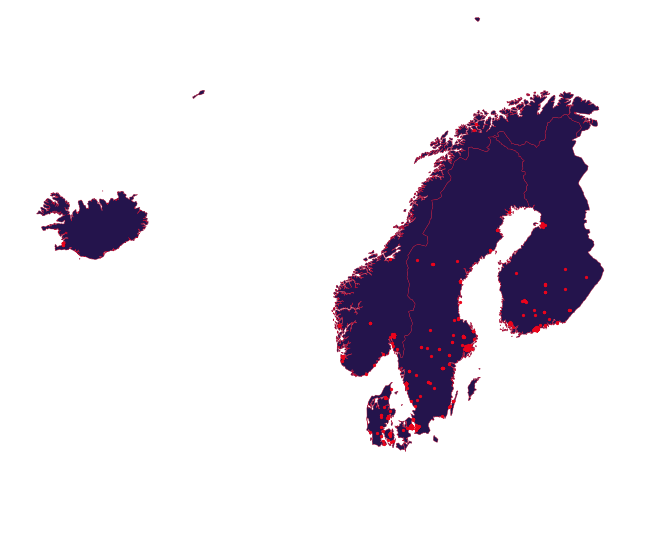

In [186]:
# Import map data
worldData = 'https://raw.githubusercontent.com/datasets/geo-countries/master/data/countries.geojson'
world = gpd.read_file(worldData)

# Filter countries present in startup data
countries = companies['HQ COUNTRY'].drop_duplicates()
countriesMap = world[world.ADMIN.isin(countries)]

# Set mercator projection base to Stockholm 
crs = countriesMap.crs.to_string()
hqMap = gpd.GeoDataFrame(companies[['LATITUDE', 'LONGITUDE', 'HQ COUNTRY']].reset_index(), 
                         geometry=gpd.points_from_xy(companies.LONGITUDE, companies.LATITUDE))
hqMap.set_crs(crs=crs, inplace=True)

# Plot the map
ax = countriesMap.plot(color='#24144c', edgecolor='#bd042b', 
                       figsize = (15,10), linewidth=0.4)
ax = hqMap.plot(ax=ax, color='#ea041c', markersize=5)

# Remove axes and focus map
ax.set_ylim(50,75)
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.patch.set_visible(False)
ax.axis('off')